In [27]:

import argparse
import json
import logging
import math
import os
import random
from pathlib import Path
import sys
import evaluate
metric = evaluate.load("rouge")
from scipy import stats

import datasets
import evaluate
import nltk
import numpy as np
import pandas as pd
import torch
from accelerate import Accelerator
from accelerate import DistributedDataParallelKwargs
from accelerate.utils import DummyOptim, DummyScheduler
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from datasets import load_dataset
from filelock import FileLock
from huggingface_hub import Repository, create_repo
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from copy import deepcopy
from torch.nn import CrossEntropyLoss
import gc
from accelerate import FullyShardedDataParallelPlugin
from peft import LoraConfig, PeftConfig, PeftModel, get_peft_model, prepare_model_for_int8_training,  TaskType
from torch.distributed.fsdp import FullyShardedDataParallel as FSDP, StateDictType, FullStateDictConfig
from peft.utils.other import fsdp_auto_wrap_policy
from datasets import Dataset
from datasets import concatenate_datasets

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import transformers
from transformers import (
    CONFIG_MAPPING,
    MODEL_MAPPING,
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    SchedulerType,
    get_scheduler,
    AutoModelForCausalLM,
)
pd.options.display.float_format = '{:,.2f}'.format
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset, load_from_disk
pd.set_option('max_colwidth', 800)

def plot_correlation_heatmap(df, threshold=0, figsize=(6, 5), spearman=False):
    import seaborn as sns
    corr = df.corr()
    if spearman:
        from scipy import stats
        res = stats.spearmanr(df.values)
        corr = pd.DataFrame(res.statistic, index=corr.index, columns=corr.columns)

    corr = corr.where(np.abs(corr) > threshold, 0)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(240, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, cbar_kws={"shrink": .8}, center=0,
                square=True, linewidths=.5, annot=True, fmt='.2f')
    plt.title("Column Correlation Heatmap")
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.title("Columns as heatmap plot")
    sns.heatmap(df, cmap='coolwarm', ax=ax)
    plt.show()
    
    return corr

In [3]:
model_name="google/flan-t5-large"
dataset_name="samsum"
N_FOLD=2

max_target_length=128
padding="max_length"


# seed = 42
# total_fractions = 2
# our_fraction = 0
# train_dataset = train_dataset.shuffle(seed).flatten_indices()
# fraction_size = len(train_dataset)//total_fractions + 1
# train_dataset = train_dataset.select(range(our_fraction * fraction_size, min((our_fraction+1) * fraction_size, len(train_dataset) - 1)))

In [4]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_dataset(dataset_name)

Found cached dataset samsum (/home/ahemf/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e)
100%|██████████| 3/3 [00:00<00:00, 565.12it/s]


In [5]:
state_dict = torch.load(f"outputs/{model_name}/{dataset_name}/folds_{N_FOLD}_combined/model.pt", map_location='cpu')
model.load_state_dict(state_dict)
model = model.eval()

<All keys matched successfully>

In [6]:
# https://github.com/huggingface/transformers/blob/v4.28.1/src/transformers/pipelines/text2text_generation.py
generator=pipeline(task='text2text-generation',model=model,tokenizer=tokenizer, max_length=max_target_length)

In [7]:
generator._forward_params

{'max_length': 128}

In [8]:
generator("summarize: A: Hi Tom, are you busy tomorrow’s afternoon?\r\nB: I’m pretty sure I am. What’s up?\r\nA: Can you go with me to the animal shelter?.\r\nB: What do you want to do?\r\nA: I want to get a puppy for my son.\r\nB: That will make him so happy.\r\nA: Yeah, we’ve discussed it many times. I think he’s ready now.\r\nB: That’s good. Raising a dog is a tough issue. Like having a baby ;-) \r\nA: I'll get him one of those little dogs.\r\nB: One that won't grow up too big;-)\r\nA: And eat too much;-))\r\nB: Do you know which one he would like?\r\nA: Oh, yes, I took him there last Monday. He showed me one that he really liked.\r\nB: I bet you had to drag him away.\r\nA: He wanted to take it home right away ;-).\r\nB: I wonder what he'll name it.\r\nA: He said he’d name it after his dead hamster – Lemmy  - he's  a great Motorhead fan :-)))",max_length=100)

[{'generated_text': 'A wants to get a puppy for her son. B will go to the animal shelter with her. A took him there last Monday. He liked a puppy that A took. He will name the puppy Lemmy.'}]

In [9]:
dsets = []
models = dict()
for FOLD in range(N_FOLD):
    ds = Dataset.load_from_disk(f"outputs/{model_name}/{dataset_name}/fold_{N_FOLD}_{FOLD}")
    ds = ds.rename_column("proba", f"proba{FOLD}")
    md = deepcopy(model)
    md.load_state_dict(torch.load(f"outputs/{model_name}/{dataset_name}/fold_{N_FOLD}_{FOLD}/model.pt", map_location = 'cpu'))
    md = md.eval()
    models[FOLD] = md
    dsets.append(ds)
    
combined_ds = Dataset.load_from_disk(f"outputs/{model_name}/{dataset_name}/folds_{N_FOLD}_combined")
models["combined"] = model
md = deepcopy(model)
md.load_state_dict(torch.load(f"outputs/{model_name}/{dataset_name}/baseline/model.pt", map_location = 'cpu'))
models["baseline"] = md


<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

In [10]:



def investigate(idx, input_text, label_text, models, generator, tokenizer, max_target_length, padding, num_beams):
    labels = tokenizer(text_target=[label_text], max_length=max_target_length, padding=padding, truncation=True)
    label_ids = labels["input_ids"][0]
    labels = [tokenizer.decode(i) for i in label_ids]

    gen_kwargs = {
                "max_length": max_target_length,
                "num_beams": num_beams,
    }

    pipeline_generation = generator(input_text, **gen_kwargs)
    pipeline_token_ids = tokenizer(text_target=[pipeline_generation[0]['generated_text']], max_length=max_target_length, padding=padding, truncation=True)
    pipeline_token_ids = pipeline_token_ids["input_ids"][0]
    pipeline_decoded = [tokenizer.decode(i) for i in pipeline_token_ids]
    model_texts = dict()
    model_texts["input"] = input_text
    model_texts["label"] = label_text
    model_texts["pipeline"] = pipeline_generation[0]['generated_text']

    
    batch = tokenizer(input_text, max_length=max_target_length, padding=padding, truncation=True, return_tensors="pt")
    model_predictions = dict()

    for FOLD, used_model in models.items():
        generated_ids = used_model.generate(
                        input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        **gen_kwargs,
                    )
        generated_ids = generated_ids.squeeze().tolist()
        if generated_ids[0] == tokenizer.pad_token_id:
            generated_ids = generated_ids[1:]
        if len(generated_ids) < max_target_length:
            generated_ids = generated_ids + [tokenizer.pad_token_id]*(max_target_length - len(generated_ids))
        generated_ids_decoded = [tokenizer.decode(i) for i in generated_ids]
        model_predictions[f"generated_token_ids_{FOLD}"] = generated_ids
        model_predictions[f"generated_tokens_{FOLD}"] = generated_ids_decoded
        model_texts[FOLD] = tokenizer.decode(generated_ids, skip_special_tokens=True)

    rouge_scores = dict()
    for FOLD, predictions in model_texts.items():
        rouge_score = metric.compute(predictions=[predictions], references=[label_text], use_stemmer=True)
        rouge_score["text"] = predictions
        rouge_scores[FOLD] = rouge_score
    rouge_df = pd.DataFrame(rouge_scores.values(), index=rouge_scores.keys())
    rouge_df


    probas_dict = combined_ds[idx]
    our_dict = {"label_ids": label_ids, "labels": labels, 
                        "pipeline_token_ids": pipeline_token_ids, "pipeline_tokens": pipeline_decoded, **model_predictions}

    probas_dict.update(our_dict)
    df = pd.DataFrame(probas_dict)
    df = df.loc[(df==tokenizer.pad_token).sum(axis=1) < 6]
    return rouge_df, df


In [11]:
idx = 2
label_text = dataset["train"][idx]["summary"]
input_text = f'summarize: {dataset["train"][idx]["dialogue"]}'
rouge_df, df = investigate(idx, input_text, label_text, models, generator, tokenizer, max_target_length, padding, num_beams=1)

rouge_df
df

,rouge1,rouge2,rougeL,rougeLsum,text
input,0.12,0.02,0.07,0.10,"summarize: Tim: Hi, what's up?\r\nKim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating\r\nTim: What did you plan on doing?\r\nKim: Oh you know, uni stuff and unfucking my room\r\nKim: Maybe tomorrow I'll move my ass and do everything\r\nKim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies\r\nTim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores\r\nTim: It really helps\r\nKim: thanks, maybe I'll do that\r\nTim: I also like using post-its in kaban style"
label,1.00,1.00,1.00,1.00,Kim may try the pomodoro technique recommended by Tim to get more stuff done.
pipeline,0.33,0.10,0.19,0.19,Kim is procrastinating. She will do some uni stuff and unfuck her room tomorrow. She will eat some defrosted vegetables instead of shopping. Tim recommends the Pomodoro technique.
0,0.10,0.00,0.10,0.10,"Kim is in a bad mood and she procrastinates. She will do some uni stuff tomorrow. Instead of shopping, she will eat some defrosted veggies."
1,0.32,0.10,0.18,0.18,Kim is in bad mood and she's not going to do a lot of things. She's going to eat vegetables instead of shopping. Tim recommends the Pomodoro technique.
combined,0.08,0.00,0.08,0.08,Kim is procrastinating and will eat some defrosted vegetables instead of shopping.
baseline,0.12,0.00,0.12,0.12,Kim is in bad mood and she's procrastinating. She's going to defrost a fridge instead of shopping.


,proba0,proba1,proba_v1,proba_v2,proba_v3,label_ids,labels,pipeline_token_ids,pipeline_tokens,generated_token_ids_0,generated_tokens_0,generated_token_ids_1,generated_tokens_1,generated_token_ids_combined,generated_tokens_combined,generated_token_ids_baseline,generated_tokens_baseline
0,0.94,0.93,0.99,0.87,0.92,6777,Kim,6777,Kim,6777,Kim,6777,Kim,6777,Kim,6777,Kim
1,0.00,0.00,1.00,0.00,0.00,164,may,19,is,19,is,19,is,19,is,19,is
2,0.03,0.07,0.97,0.00,0.03,653,try,813,pro,16,in,16,in,813,pro,16,in
3,0.46,0.55,0.90,0.25,0.41,8,the,2935,cra,3,,1282,bad,2935,cra,1282,bad
4,0.06,0.37,0.68,0.02,0.04,3,,7,s,9,a,6526,mood,7,s,6526,mood
5,1.00,1.00,1.00,1.00,1.00,17043,pom,17,t,1282,bad,11,and,17,t,11,and
6,1.00,1.00,1.00,1.00,1.00,7512,odor,77,in,6526,mood,255,she,77,in,255,she
7,1.00,1.00,1.00,1.00,1.00,32,o,1014,ating,11,and,31,',1014,ating,31,'
8,0.27,0.87,0.40,0.24,0.11,3317,technique,5,.,255,she,7,s,11,and,7,s
9,0.01,0.20,0.81,0.00,0.01,3024,recommended,451,She,813,pro,59,not,56,will,813,pro


In [17]:
probas_df_only = df[['proba0', 'proba1', 'proba_v1', 'proba_v2', 'proba_v3']]
pearson_corr_metrics = probas_df_only.corr()

res = stats.spearmanr(probas_df_only.values)
spearman_corr_metrics = pd.DataFrame(res.statistic, index=pearson_corr_metrics.index, columns=pearson_corr_metrics.columns)
pearson_corr_metrics
spearman_corr_metrics

,proba0,proba1,proba_v1,proba_v2,proba_v3
proba0,1.00,0.89,0.52,0.99,1.00
proba1,0.89,1.00,0.07,0.89,0.86
proba_v1,0.52,0.07,1.00,0.51,0.57
proba_v2,0.99,0.89,0.51,1.00,0.99
proba_v3,1.00,0.86,0.57,0.99,1.00


,proba0,proba1,proba_v1,proba_v2,proba_v3
proba0,1.00,0.88,0.59,0.96,0.99
proba1,0.88,1.00,0.44,0.95,0.86
proba_v1,0.59,0.44,1.00,0.52,0.64
proba_v2,0.96,0.95,0.52,1.00,0.95
proba_v3,0.99,0.86,0.64,0.95,1.00


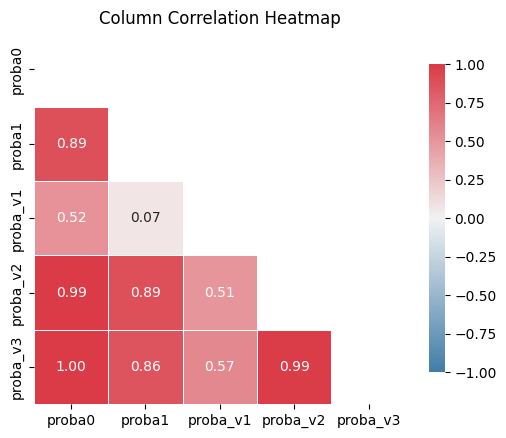

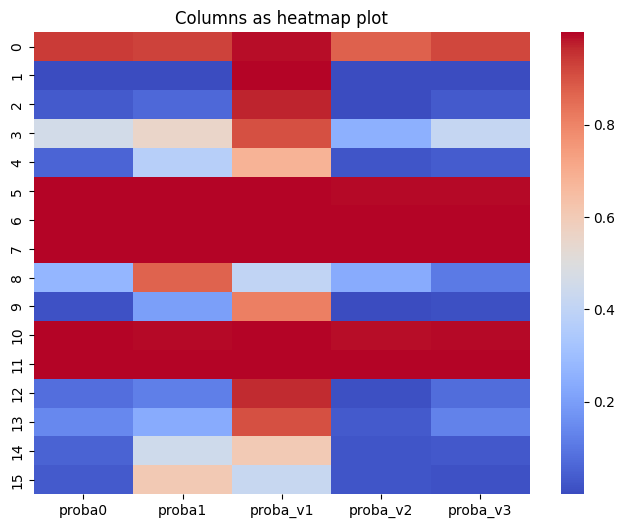

,proba0,proba1,proba_v1,proba_v2,proba_v3
proba0,1.00,0.89,0.52,0.99,1.00
proba1,0.89,1.00,0.07,0.89,0.86
proba_v1,0.52,0.07,1.00,0.51,0.57
proba_v2,0.99,0.89,0.51,1.00,0.99
proba_v3,1.00,0.86,0.57,0.99,1.00


In [25]:
plot_correlation_heatmap(probas_df_only)

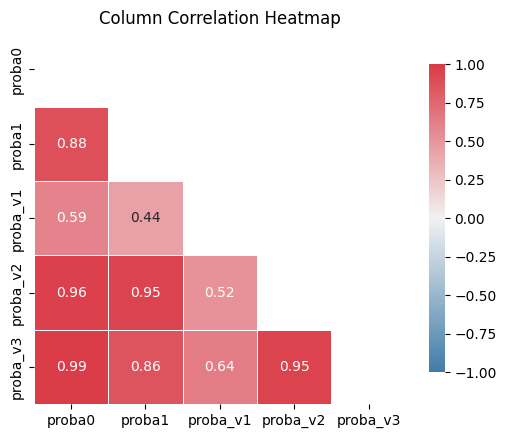

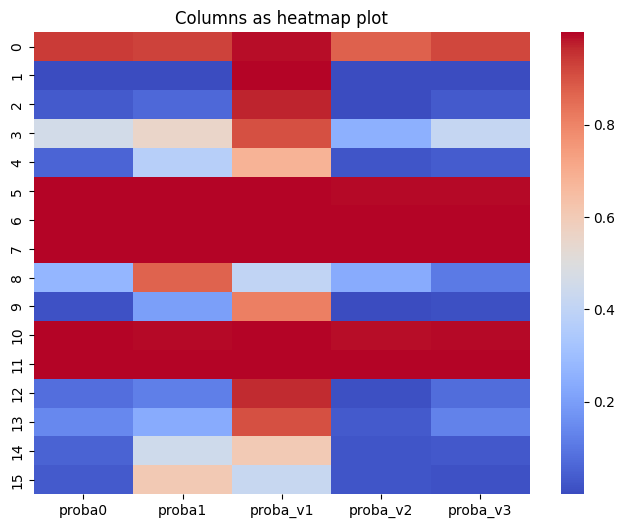

,proba0,proba1,proba_v1,proba_v2,proba_v3
proba0,1.00,0.88,0.59,0.96,0.99
proba1,0.88,1.00,0.44,0.95,0.86
proba_v1,0.59,0.44,1.00,0.52,0.64
proba_v2,0.96,0.95,0.52,1.00,0.95
proba_v3,0.99,0.86,0.64,0.95,1.00


In [26]:
plot_correlation_heatmap(probas_df_only, spearman=True)

In [104]:
idx = 4
label_text = dataset["train"][idx]["summary"]
input_text = f'summarize: {dataset["train"][idx]["dialogue"]}'
rouge_df, df = investigate(idx, input_text, label_text, models, generator, tokenizer, max_target_length, padding, num_beams=1)

rouge_df
df

,rouge1,rouge2,rougeL,rougeLsum,text
input,0.16,0.06,0.11,0.13,"summarize: Sam: hey overheard rick say something\r\nSam: i don't know what to do :-/\r\nNaomi: what did he say??\r\nSam: he was talking on the phone with someone\r\nSam: i don't know who\r\nSam: and he was telling them that he wasn't very happy here\r\nNaomi: damn!!!\r\nSam: he was saying he doesn't like being my roommate\r\nNaomi: wow, how do you feel about it?\r\nSam: i thought i was a good rommate\r\nSam: and that we have a nice place\r\nNaomi: that's true man!!!\r\nNaomi: i used to love living with you before i moved in with me boyfriend\r\nNaomi: i don't know why he's saying that\r\nSam: what should i do???\r\nNaomi: honestly if it's bothering you that much you should talk to him\r\nNaomi: see what's going on\r\nSam: i don't want to get in any kind of confrontation though\r\nSam:..."
label,1.00,1.00,1.00,1.00,"Sam is confused, because he overheard Rick complaining about him as a roommate. Naomi thinks Sam should talk to Rick. Sam is not sure what to do."
pipeline,0.39,0.05,0.30,0.30,Sam overheard Rick saying he doesn't like being Sam's roommate. Sam doesn't want to confront Rick.
0,0.41,0.22,0.41,0.41,Sam overheard Rick complaining about his roommate. Sam is upset about it.
1,0.29,0.06,0.18,0.18,Rick is not happy as his roommate.
combined,0.26,0.05,0.21,0.21,Sam overheard Rick saying that he doesn't like being his roommate.
baseline,0.41,0.22,0.41,0.41,Sam overheard Rick complaining about his roommate. Sam is upset about it.


,proba0,proba1,proba_v1,proba_v2,proba_v3,label_ids,labels,pipeline_token_ids,pipeline_tokens,generated_token_ids_0,generated_tokens_0,generated_token_ids_1,generated_tokens_1,generated_token_ids_combined,generated_tokens_combined,generated_token_ids_baseline,generated_tokens_baseline
0,0.41,0.06,0.65,0.02,0.04,3084,Sam,3084,Sam,3084,Sam,11066,Rick,3084,Sam,3084,Sam
1,0.07,0.17,0.90,0.01,0.06,19,is,147,over,147,over,19,is,147,over,147,over
2,0.07,0.04,0.96,0.00,0.03,11319,confused,88,he,88,he,59,not,88,he,88,he
3,0.10,0.09,0.99,0.01,0.09,6,",",986,ard,986,ard,1095,happy,986,ard,986,ard
4,0.73,0.53,0.80,0.39,0.42,250,because,11066,Rick,11066,Rick,38,as,11066,Rick,11066,Rick
5,0.79,0.83,0.96,0.66,0.76,3,,2145,saying,24184,complaining,112,his,2145,saying,24184,complaining
6,0.98,0.93,0.95,0.92,0.89,88,he,3,,81,about,562,room,24,that,81,about
7,0.09,0.04,0.94,0.00,0.03,147,over,88,he,112,his,5058,mate,3,,112,his
8,1.00,1.00,1.00,1.00,1.00,88,he,744,doesn,562,room,5,.,88,he,562,room
9,1.00,0.89,0.89,0.88,0.79,986,ard,31,',5058,mate,1,</s>,744,doesn,5058,mate


In [105]:
rouge_df, df = investigate(idx, input_text, label_text, models, generator, tokenizer, max_target_length, padding, num_beams=10)

rouge_df
df

,rouge1,rouge2,rougeL,rougeLsum,text
input,0.16,0.06,0.11,0.13,"summarize: Sam: hey overheard rick say something\r\nSam: i don't know what to do :-/\r\nNaomi: what did he say??\r\nSam: he was talking on the phone with someone\r\nSam: i don't know who\r\nSam: and he was telling them that he wasn't very happy here\r\nNaomi: damn!!!\r\nSam: he was saying he doesn't like being my roommate\r\nNaomi: wow, how do you feel about it?\r\nSam: i thought i was a good rommate\r\nSam: and that we have a nice place\r\nNaomi: that's true man!!!\r\nNaomi: i used to love living with you before i moved in with me boyfriend\r\nNaomi: i don't know why he's saying that\r\nSam: what should i do???\r\nNaomi: honestly if it's bothering you that much you should talk to him\r\nNaomi: see what's going on\r\nSam: i don't want to get in any kind of confrontation though\r\nSam:..."
label,1.00,1.00,1.00,1.00,"Sam is confused, because he overheard Rick complaining about him as a roommate. Naomi thinks Sam should talk to Rick. Sam is not sure what to do."
pipeline,0.39,0.05,0.30,0.30,Sam overheard Rick saying he doesn't like being Sam's roommate. Sam doesn't want to confront Rick.
0,0.38,0.11,0.24,0.24,Sam overheard Rick telling someone that he doesn't like being Sam's roommate. Sam is upset because he thought Rick was a good roommate and they have a good relationship.
1,0.24,0.00,0.10,0.10,Rick was talking on the phone with someone and said he doesn't like being Sam's roommate. Sam thought he was a good rommate and that they have a good relationship.
combined,0.30,0.05,0.20,0.20,Sam overheard Rick saying that he doesn't like being Sam's roommate.
baseline,0.29,0.05,0.20,0.20,Sam overheard Rick telling someone that he doesn't like being Sam's roommate.


,proba0,proba1,proba_v1,proba_v2,proba_v3,label_ids,labels,pipeline_token_ids,pipeline_tokens,generated_token_ids_0,generated_tokens_0,generated_token_ids_1,generated_tokens_1,generated_token_ids_combined,generated_tokens_combined,generated_token_ids_baseline,generated_tokens_baseline
0,0.41,0.06,0.65,0.02,0.04,3084,Sam,3084,Sam,3084,Sam,11066,Rick,3084,Sam,3084,Sam
1,0.07,0.17,0.90,0.01,0.06,19,is,147,over,147,over,47,was,147,over,147,over
2,0.07,0.04,0.96,0.00,0.03,11319,confused,88,he,88,he,2508,talking,88,he,88,he
3,0.10,0.09,0.99,0.01,0.09,6,",",986,ard,986,ard,30,on,986,ard,986,ard
4,0.73,0.53,0.80,0.39,0.42,250,because,11066,Rick,11066,Rick,8,the,11066,Rick,11066,Rick
5,0.79,0.83,0.96,0.66,0.76,3,,2145,saying,5188,telling,951,phone,2145,saying,5188,telling
6,0.98,0.93,0.95,0.92,0.89,88,he,3,,841,someone,28,with,24,that,841,someone
7,0.09,0.04,0.94,0.00,0.03,147,over,88,he,24,that,841,someone,3,,24,that
8,1.00,1.00,1.00,1.00,1.00,88,he,744,doesn,3,,11,and,88,he,3,
9,1.00,0.89,0.89,0.88,0.79,986,ard,31,',88,he,243,said,744,doesn,88,he
